## Simulation and POD analysis of the marginally turbulent flow in an open channel at low Reynolds number using `Nek5000`
> Daniele Massaro, Saleh Rezaeiravesh and Philipp Schlatter <br />
  dmassaro@mech.kth.se, salehr@mech.kth.se, pschlatt@mech.kth.se <br />
  SimEx/FLOW, KTH Engineering Mechanics, Royal Institute of Technology, Stockholm, Sweden

This is a short tutorial for the simulation of the turbulent flow in an open channel at low Reynolds number ($Re_b=2000$), and the analysis of the velocity fields using 3D POD.

The streamwise, wall-normal, and spanwise coordinates are specified by $x$, $y$, and $z$, respectively. The flow is periodic in both $x$ and $z$ directions. The lower boundary condition at $y=0$ is a solid wall (no slip boundary condition) and at $y=1$ a slip condition ($\partial u/\partial y=v=\partial w/\partial y = 0$). 

## 1. Nek5000 source code and POD

We use the standard `Nek5000` code which can be cloned from [here](https://github.com/Nek5000/Nek5000). If you want you can also use the KTH-Framework extension of `Nek5000` which can be cloned from [here](https://github.com/KTH-Nek5000/KTH_Framework). 

The source files of the minimal channel can be downloaded from [here](https://github.com/KTH-Nek5000/TurbCourse/tree/main/minimal_channel). You will need `channel.box`, `SIZE`, `channel.usr` and `channel.par`.

The POD code can be downloaded from [here](https://github.com/KTH-Nek5000/TurbCourse/tree/main/pod/channel). In order to read and write Nek5000 files, you will need the package `pymech`. Unfortunately, the packaged version does not include single 32-bit floats. Therefore, you cannot use the pip version of the Nek readers, but rather fork them from [here](https://github.com/danielemassaro/pymech). The easiest way is to install the pip version, and then replace the relevant part with the forked one.

## 2. Flow simulation

The case is called `channel`. In the following, different steps are briefly explained to set up and run the simulation as well as computing POD. 

### 2.1. Mesh Generation & Specifying Boundary Conditions

We use the internal mesh generator of `Nek5000` to create a uniform mesh for a 3D square box. Then, in the `.usr` file, the coordinates of the points of the geometry and mesh are adjusted at the first time step to obtain the geomtery of the periodic hill with a structured mesh. 

- In `channel.box`, the size of the box, and mesh size are set:
  * Line 6: Number of elements in $x$, $y$, and $z$ directions (as negative numbers)
  * Lines 7-9: Starting location, final location, and stretching of the mesh elements in $x$, $y$, and $z$. 
  * Line 10: Boundary conditions of the six faces of the box with normals in $-x$, $+x$, $-y$, $+y$, $-z$, and $+z$ are respectively set as: `P  ,P  ,W  ,SYM,P  ,P  `, where, `W`=wall, `P`=periodic and `SYM`=symmetry. 
  
- To create the box and its mesh: run `genbox` which is a `Nek5000` standard tool. This results in `box.re2`. Rename this file as `channel.re2`.

- Map the mesh by `genmap` and create `channel.ma2`. 

When `Nek5000` is compiled and run, the box is mapped into an open channel. This is achieved by the subroutine `userdat` in `channel.usr`. The dimension of the channel as well as the mesh stretching parameters in the wall-normal directions are specified in subroutine `usrdat`. 

Since the flow is periodic in the streamwise direction, a forcing term is required to keep the mass flow rate constant at each time step during the simulation. 

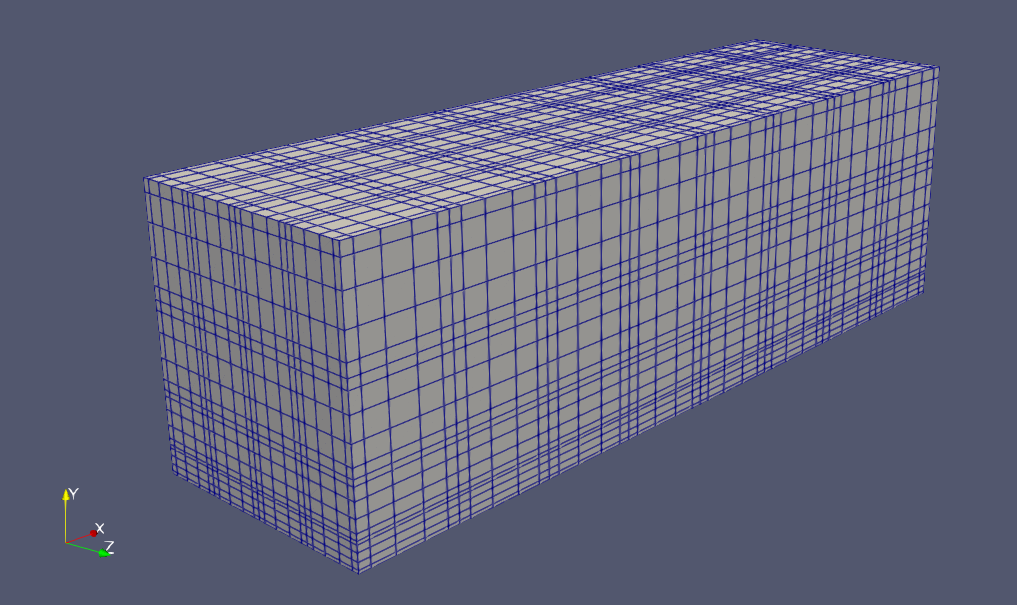



<center>The mesh created by the box file for the channel geometry.</center>


### 2.2. Compilation

- First, the following should be set in `SIZE`:
    * `lx1`: Number of Gauss-Lobatto-Legendre (GLL) points per element per dimension. 
    * `lxd`: Number of quadrature points for dealiasing (over-integration). We take the integer part of $lxd=3/2\, lx1$.
    * `lelg`: Total number of elements which is obtained from what is set in `channel.box`. This parameter is allowed to be set to a larger value than the actual number of elements, but not less! 
    * `lelt`: Maximum total number of elements per MPI rank. This value can be set considering the minimum MPI rank to be used to run the case. 
    The rest of parameters are kept as default. 

- Next, we need to set the required parameters in the compilation script `compile_script`:
    * Set the absolute path to `Nek5000` source code in `NEK_SOURCE_ROOT`.
    * Set appropriate FORTRAN and C compilers to `FC` and `CC`, respectively. The default is `FC=mpifort` and `CC=mpicc`. 
    
To compile, run `./compile_script --all`. The compilation report will be written in `build.log`.

For cleaning old compilation files, run `./compile_script --clean` and then type `Y`.     

### 2.3. Running the case

After compiling the case, the object file `nek5000` is created which can be executed. To run the case with, for instance, 4 processors, type

`mpirun -np 4 nek5000 >>logfile&`

However, prior to this, two things should be done:

1. Create a file named `SESSION.NAME`. The first line is the case name, i.e. `channel` and the second line is the absolute path to the case directory (do not forget `/` at the end of the path).

2. Set the simulation parameters in `channel.par`. The parameters include:
   * Maximum number of time steps `numSteps`
   * Time step size, `dt`. For a constant $\Delta t$ set a negative value, a positive one gives the maximum
   * Interval of saving flow fields `writeInterval`
   * Reynolds number or viscosity, `viscosity`. If a negative value is set, it will be considered as the Reynolds number. 

List of the output files:
   * `channel0.f*`: snapshots of the flow fields written at intervals `writeInterval`.

**Contour plots of the snapshots:**
The snapshot fields `channel0.f*` can be plotted using [`ParaView`](https://www.paraview.org/) or [`VisIt`](https://wci.llnl.gov/simulation/computer-codes/visit). To this end, we need to first run `visnek` command in the case root. This creates `channel.nek5000` which can be opened in the mentioned software. 

<img src="./static_figs/minimal.png" alt="drawing" width="600"/>

<center>Isosurface of an instantaneous field of streamwise velocity, and vertical plane with streamwise velocity.</center>

Note that this case may be run for longer than the given example ($t_\mathrm{max} = 1000$). However, as always with minimal channels there is a chance of re-laminarising.

If you cannot get the simulation to work, you can download the snapshots fromt his simulation [here](https://kth-my.sharepoint.com/:u:/g/personal/philipps_ug_kth_se/EbMQ_Pw2rQJMqez5KuK_eCABxYQ3zCC8LUZPB4kX-bvRgw?e=eP4lA1).

## 3. POD analysis

Once all the snapshots are created, including also the mass matrix `bm1` in the file `bm1channel0.f00001`, you can run the POD code located [here](https://github.com/KTH-Nek5000/TurbCourse/tree/main/pod/channel).

Edit the file `input.txt` according to your needs, in particular `path_in` and `path_out`, and then run `python ddmMain.py`.

In your output directory, you will then find two `.nek5000`files that can be visualised using Paraview or Visit: `PODmodchannel.nek5000` (containing the POD modes) and `PODsnaprcnchannel.nek5000` (containing a reconstructed low-order series of the flow).

You will also get the POD spectrum, and some sample time series. How they behave, we will discuss during the tutorial.

<img src="./static_figs/streak.png" alt="drawing" width="600"/>

<center>First POD mode for the minimal channel. Together with mode 2 they build up the streaks.</center>

<img src="./static_figs/streak-instab.png" alt="drawing" width="600"/>

<center>Mode 3 for the minimal channel. Together with modes 4, 7, 8 they build up the streak instability. Note that the numbering may differ depending on the number of snapshots, spacing etc.</center>

As an important side note we should mention that the POD decomposition in homogeneous directions (periodic directions) will converge to a Fourier decomposition in the limit of sufficient number of snapshots. This means that in this case in principle only the vertical $y$ direction needs to be treated via POD, and the $x$ and $z$ direction should be decomposed using Fourier, e.g. using an FFT. This is not part of the current tutorial, but can of course be implemented (see also the reference by Webber et al. below).

## References

Relevant references for this type of POD analysis:

- Malm, J., Bagheri, S., Schlatter, P. and Henningson, D. S., Koopman mode decompisition of a minimal
channel flow, 2011: [link to thesis](https://www.mech.kth.se/thesis/2011/phd/phd_2011_johan_malm.pdf), page 123

- Webber, G. A., Handler, R. A. and Sirovich, L., The Karhunen–Loève decomposition of minimal channel flow,
Physics of Fluids 9, 1054 (1997): [doi](https://doi.org/10.1063/1.869323)